In [2]:
# 任务:
# 1. 读入 FashionMNIST, MNIST, CIFAR10 数据集
# 2. 挑 9 张图片进行 3x3 的可视化
# 3. 搭建 MLP 网络, 写 train/eval loop, 带调试信息
# 4. 进行训练, 保存模型
# 5. 加载模型, 进行推理

# 数据集导入
from torchvision import datasets, transforms

op_dataset = 2  # 0: FashionMNIST, 1: MNIST, 2: CIFAR10
'''
数据集介绍:
0. FashionMNIST: 10 个类别, 60000 训练样本, 10000 测试样本, 28x28 灰度图像
1. MNIST: 10 个类别, 60000 训练样本, 10000 测试样本, 28x28 灰度图像
2. CIFAR10: 10 个类别, 50000 训练样本, 10000 测试样本, 32x32 彩色图像
'''

if op_dataset == 0:
    dataset_name = 'FashionMNIST'
    train_data = datasets.FashionMNIST(
        root='./data',
        train=True,
        transform=transforms.ToTensor(),
        download=True,
    )
    test_data = datasets.FashionMNIST(
        root='./data',
        train=False,
        transform=transforms.ToTensor(),
        download=True,
    )
elif op_dataset == 1:
    dataset_name = 'MNIST'
    train_data = datasets.MNIST(
        root='./data',
        train=True,
        transform=transforms.ToTensor(),
        download=True,
    )
    test_data = datasets.MNIST(
        root='./data',
        train=False,
        transform=transforms.ToTensor(),
        download=True,
    )
elif op_dataset == 2:
    dataset_name = 'CIFAR10'
    train_data = datasets.CIFAR10(
        root='./data',
        train=True,
        transform=transforms.ToTensor(),
        download=True,
    )
    test_data = datasets.CIFAR10(
        root='./data',
        train=False,
        transform=transforms.ToTensor(),
        download=True,
    )

print('训练集样本数量 和 测试集样本数量:')
print(len(train_data), len(test_data))
print('样本的形状和标签:')
print(train_data[0][0].shape, train_data[0][1])

Files already downloaded and verified
Files already downloaded and verified
训练集样本数量 和 测试集样本数量:
50000 10000
样本的形状和标签:
torch.Size([3, 32, 32]) 6


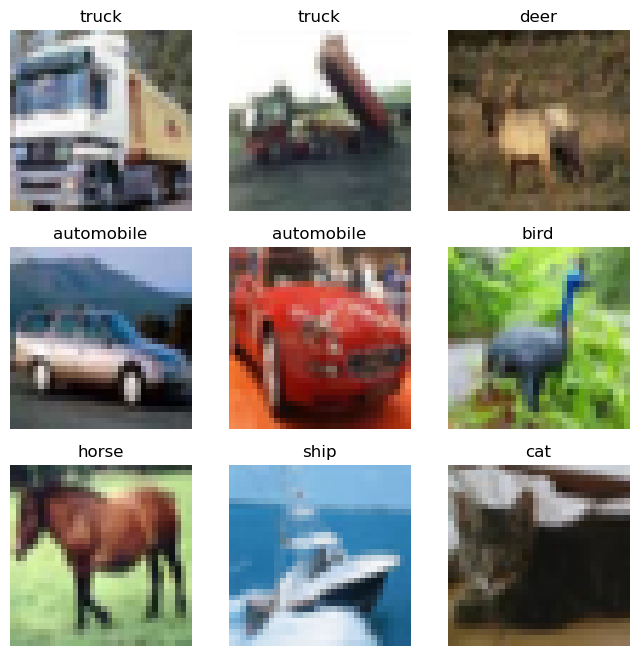

In [3]:
# 可视化
import matplotlib.pyplot as plt

label_name_map = [
    ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'],
    ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'],
]

fig = plt.figure(figsize=(8, 8))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    plt.subplot(rows, cols, i)
    plt.title(label_name_map[op_dataset][train_data[i][1]])
    plt.axis('off')
    if op_dataset < 2:
        plt.imshow(train_data[i][0].squeeze(), cmap='gray') # gray 模式的 input 为 H x W
    elif op_dataset == 2:
        plt.imshow(train_data[i][0].permute(1, 2, 0)) # RGB 模式的 input 为 H x W x C
        # permute(1, 2, 0) 相当于原本索引为 1 的维度放到索引为 0 的位置, 以此类推
plt.show()

In [4]:
# 搭建网络
from torch import nn
import torch

input_dim = train_data[0][0].numel()  # 拿到第一个样本的特征的元素个数

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.seq = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    def forward(self, input):
        logits = self.seq(self.flatten(input))
        return logits

# 准备训练
from torch.utils.data import DataLoader

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloaer = DataLoader(test_data, batch_size=batch_size, shuffle=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = MLP().to(device)
loss_fn = torch.nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

def train_loop(model, dataloader, loss_fn, optimizer):
    model.train()
    samples_size, batches_size = len(dataloader.dataset), len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred_logits = model(X)
        loss = loss_fn(pred_logits, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0 or batch == batches_size - 1:
            samples_now = batch * batch_size + len(y)
            print(f'loss:{loss:<5.2f} | progress:{samples_now}/{samples_size}')

def test_loop(model, dataloader, loss_fn):
    model.eval()
    samples_size, batches_size = len(dataloader.dataset), len(dataloader)
    loss_sum, acc_sum = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred_logits = model(X)
        loss = loss_fn(pred_logits, y)
        
        loss_sum += loss
        y_pred = pred_logits.argmax(dim=1)
        acc_sum += (y_pred == y).sum()
    
    print(f'avg loss:{(loss_sum/batches_size):<5.2f} | acc:{(acc_sum/samples_size*100):<5.2f}%')

epochs = 10
for t in range(1, epochs + 1):
    print(f'Epochs {t} ---------------------------------')
    train_loop(model, train_dataloader, loss_fn, optimizer)
    test_loop(model, test_dataloaer, loss_fn)
    print()

# 保存模型
import os
if not os.path.exists('./model'):
    os.mkdir('./model')
save_name = './model/MLP' + '_' + dataset_name + '.pth'
torch.save(model.state_dict(), save_name)

Epochs 1 ---------------------------------
loss:2.30  | progress:64/50000
loss:2.30  | progress:6464/50000
loss:2.29  | progress:12864/50000
loss:2.29  | progress:19264/50000
loss:2.29  | progress:25664/50000
loss:2.30  | progress:32064/50000
loss:2.27  | progress:38464/50000
loss:2.29  | progress:44864/50000
loss:2.26  | progress:50000/50000
avg loss:2.27  | acc:14.40%

Epochs 2 ---------------------------------
loss:2.28  | progress:64/50000
loss:2.29  | progress:6464/50000
loss:2.27  | progress:12864/50000
loss:2.26  | progress:19264/50000
loss:2.25  | progress:25664/50000
loss:2.26  | progress:32064/50000
loss:2.23  | progress:38464/50000
loss:2.23  | progress:44864/50000
loss:2.25  | progress:50000/50000
avg loss:2.23  | acc:20.37%

Epochs 3 ---------------------------------
loss:2.21  | progress:64/50000
loss:2.22  | progress:6464/50000
loss:2.21  | progress:12864/50000
loss:2.23  | progress:19264/50000
loss:2.25  | progress:25664/50000
loss:2.22  | progress:32064/50000
loss:2.19

In [12]:
# 加载模型并进行推理
model = MLP().to(device)
model.load_state_dict(torch.load(save_name))    # 新版本 torch 推荐加上 weights_only=True
model.eval()

id = 0
input, label = train_data[id][0], train_data[id][1]   # 只要第一个样本

input = input.unsqueeze(0).to(device)  # 增加 batch 维度

with torch.no_grad():
    pred_logits = model(input)
pred_y = pred_logits.argmax()
print(pred_y, label)

tensor(6, device='cuda:0') 6
